# Курсовой проект
---

## Задача<a class="anchor" id="task"></a>
***

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).

### Примерное описание этапов выполнения курсового проекта
***
**Построение модели классификации**
1. Обзор обучающего датасета
2. Анализ данных
3. Обработка пропусков
4. Обработка выбросов
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## 1. Обзор данных
---
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
%%time
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy import nan

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

CPU times: total: 1.91 s
Wall time: 1.96 s


### Функции

#### Обработка признаков

**Обработка категориальных признаков**

In [2]:
def process_cat_features(df_input):
    df_input['Years in current job'] = df_input['Years in current job'].replace(
        {'< 1 year': 0.0, '1 year': 1.0, '2 years': 2.0,
         '3 years': 3.0, '4 years': 4.0, '5 years': 5.0,
         '6 years': 6.0, '7 years': 7.0, '8 years': 8.0,
         '9 years': 9.0, '10+ years': 10.0}).astype(float)
    
    cat_rep = {col: {k: v for v, k in enumerate(df_input[col].unique())} for col in df_input.select_dtypes(object).columns}
    print(cat_rep)
    df_input.replace(cat_rep, inplace=True)

    return df_input

~~**Генерация новых признаков**~~

In [3]:
# def cat_features_generation(df_input):
#     temp = df_input.groupby('Home Ownership', as_index=False).mean()[['Home Ownership', 'Credit Default']].rename(columns={
#         'Credit Default': 'target_Home_Ownership'
#     })
#     temp = pd.DataFrame(temp)
#     df_input = df_input.merge(temp, on='Home Ownership', how='left')

#     temp = df_input.groupby('Purpose', as_index=False).mean()[['Purpose', 'Credit Default']].rename(columns={
#         'Credit Default': 'target_Purpose'})
#     temp = pd.DataFrame(temp)
#     df_input = df_input.merge(temp, on='Purpose', how='left')
#     return df_input

**Oбработка выбросов заменой на $\mathsf{NaN}$**

In [4]:
def process_outlier_values(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

#### Построение и оценка модели

**Метрики качества модели**

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [6]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN\n", round(f1_score(y_train, y_train_pred), 3))
    print("VALID\n", round(f1_score(y_valid, y_valid_pred), 3))
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

#### Балансировка целевой переменной

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [9]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0.0']['f1-score']
    f1_1 = report['1.0']['f1-score']
    return f1_macro, f1_0, f1_1

In [10]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Подбор оптимального размера выборки, кривая обучения**

In [11]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

#### Выбор порога вероятности для определения класса

In [12]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    plt.show()

**Важность признаков**

In [13]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Пути к директориям и файлам

In [14]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
SOURCE_TRAIN_SET_PATH = DATA_ROOT / './source/train.csv'
SOURCE_TEST_SET_PATH = DATA_ROOT / './source/test.csv'
SOURCE_SAMPLE_SUBMIT_PATH = DATA_ROOT / './source/sample_submission.csv'

# output
TRAIN_FULL_SET_PATH = DATA_ROOT /'train_FULL_SET.csv'
TRAIN_PART_PATH = DATA_ROOT / 'train_TRAIN_part.csv'
VALID_PART_PATH = DATA_ROOT / 'train_VALID_part.csv'

PREPARED_TEST_SET_PATH = DATA_ROOT /'test_prepared.csv'

# models
SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model_final.pkl'

# predictions
PREDICTIONS_FILE_PATH = DATA_ROOT /'predictions_final.csv'

**Загрузка данных**

In [15]:
df_train_base = pd.read_csv(SOURCE_TRAIN_SET_PATH)
df_test_base = pd.read_csv(SOURCE_TEST_SET_PATH)

In [16]:
df_train_base.shape

(7500, 17)

In [17]:
df_test_base.shape

(2500, 16)

## 2. Анализ данных (EDA)
---
### Обзор обучающей выборки

In [18]:
df_train_base.head().T

,0,1,2,3,4
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,NaN,10+ years,8 years,6 years,8 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


In [19]:
df_train_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Из описания обучающей выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies

In [20]:
df_train_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


#### Выделение целевой переменной и групп признаков

In [21]:
BASE_TARGET_NAME = 'Credit Default'

BASE_NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score']

BASE_CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

BASE_SELECTED_FEATURE_NAMES = BASE_NUM_FEATURE_NAMES + BASE_CAT_FEATURE_NAMES

#### Анализ значений целевой переменной

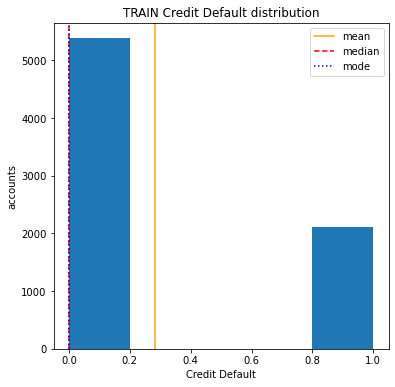

In [22]:
df_train_base[BASE_TARGET_NAME].hist(figsize=(6, 6), bins=5, grid=False)
plt.axvline(x=df_train_base['Credit Default'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Credit Default'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_train_base['Credit Default'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Credit Default')
plt.title('TRAIN Credit Default distribution')
plt.legend()
plt.show()

In [23]:
df_train_base[BASE_TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [24]:
disbalance = df_train_base[BASE_TARGET_NAME].value_counts()[0] / df_train_base[BASE_TARGET_NAME].value_counts()[1]
print(f'Дисбаланс классов в исходном сете: [0] : [1] = {disbalance} : 1')

Дисбаланс классов в исходном сете: [0] : [1] = 2.549455750118315 : 1


Соотношение класов в целевой переменной $2,55 : 1$. При построении модели нужно сделать балансировку классов.

#### Анализ числовых признаков

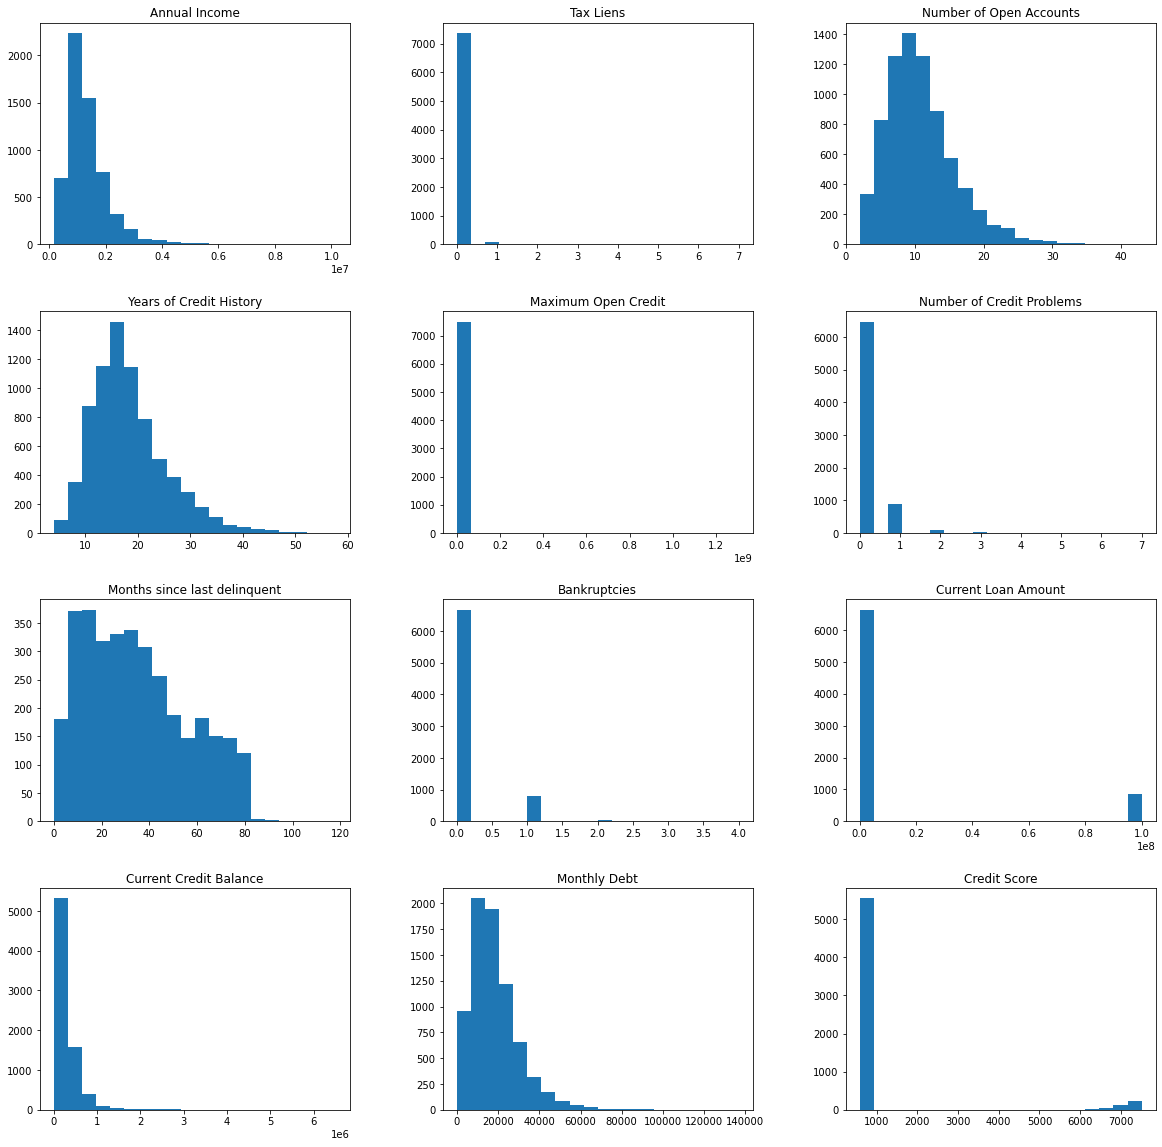

In [25]:
df_train_base[BASE_NUM_FEATURE_NAMES].hist(figsize=(20, 20), bins=20, grid=False);

In [26]:
for num_colname in df_train_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1338113.0    4
969475.0     4
1161660.0    4
1043651.0    4
1058376.0    4
            ..
1272316.0    1
712082.0     1
695476.0     1
678889.0     1
402192.0     1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      

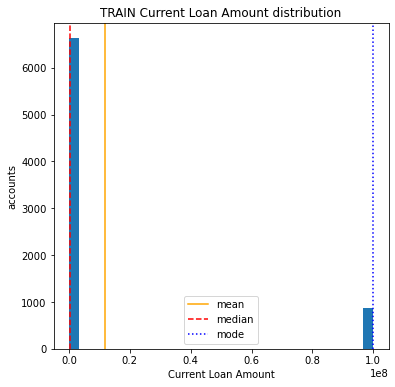

In [27]:
df_train_base['Current Loan Amount'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Current Loan Amount'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Current Loan Amount'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_train_base['Current Loan Amount'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Current Loan Amount')
plt.title('TRAIN Current Loan Amount distribution')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Credit Default'>

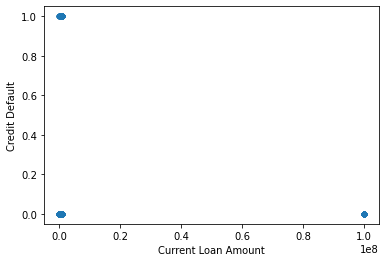

In [28]:
df_train_base.plot(x='Current Loan Amount', y=BASE_TARGET_NAME, kind='scatter')

In [29]:
Current_Loan_Amount_gap_filter = df_train_base['Current Loan Amount'] > 99999000
df_train_base.loc[Current_Loan_Amount_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,49438.0,18257.0,737.0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,83638.0,16473.0,742.0,0


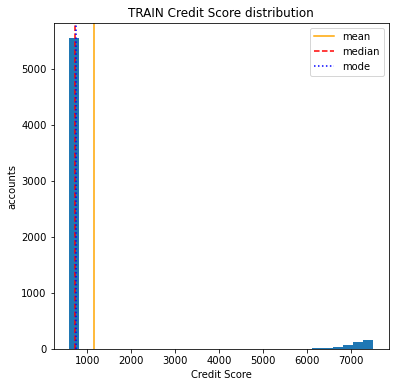

In [30]:
df_train_base['Credit Score'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Credit Score'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Credit Score'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_train_base['Credit Score'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Credit Score')
plt.title('TRAIN Credit Score distribution')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Credit Score', ylabel='Credit Default'>

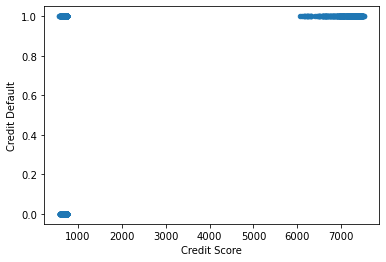

In [31]:
df_train_base.plot(x='Credit Score', y=BASE_TARGET_NAME, kind='scatter')

In [32]:
Credit_Score_gap_filter = df_train_base['Credit Score'] > 1000
df_train_base.loc[Credit_Score_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


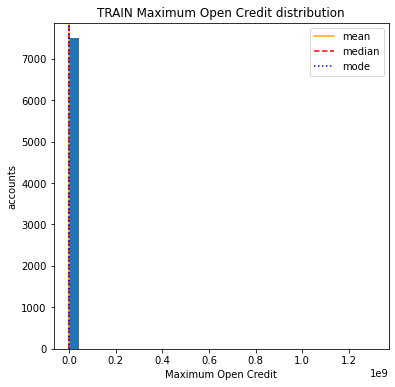

In [33]:
df_train_base['Maximum Open Credit'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Maximum Open Credit'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Maximum Open Credit'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_train_base['Maximum Open Credit'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Maximum Open Credit')
plt.title('TRAIN Maximum Open Credit distribution')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Credit Default'>

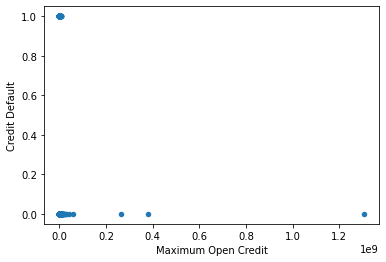

In [34]:
df_train_base.plot(x='Maximum Open Credit', y=BASE_TARGET_NAME, kind='scatter')

In [35]:
Maximum_Open_Credit_gap_filter = df_train_base['Maximum Open Credit'] > 99999000
df_train_base.loc[Maximum_Open_Credit_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0


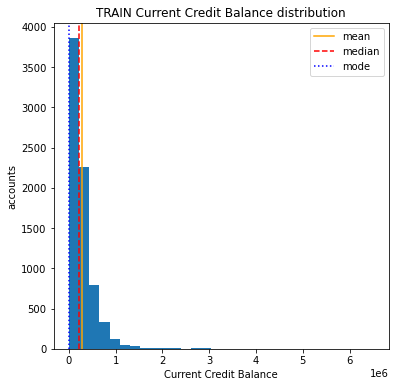

In [36]:
df_train_base['Current Credit Balance'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_train_base['Current Credit Balance'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_train_base['Current Credit Balance'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_train_base['Current Credit Balance'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Current Credit Balance')
plt.title('TRAIN Current Credit Balance distribution')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Credit Default'>

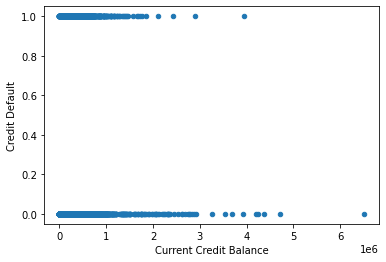

In [37]:
df_train_base.plot(x='Current Credit Balance', y=BASE_TARGET_NAME, kind='scatter')

In [38]:
Current_Credit_Balance_gap_filter = df_train_base['Current Credit Balance'] > 1000000
df_train_base.loc[Current_Credit_Balance_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
13,Rent,2066364.0,10+ years,0.0,11.0,17.7,1654026.0,0.0,NaN,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0,1
14,Own Home,2258796.0,7 years,0.0,11.0,17.7,1602546.0,0.0,NaN,0.0,other,Short Term,185262.0,1374327.0,58352.0,748.0,0
25,Rent,1353142.0,10+ years,0.0,3.0,29.8,1231912.0,0.0,NaN,0.0,other,Short Term,108042.0,1036279.0,22225.0,720.0,0
93,Home Mortgage,NaN,10+ years,0.0,18.0,17.9,3028014.0,0.0,NaN,0.0,debt consolidation,Short Term,311168.0,2327443.0,55716.0,NaN,0
133,Home Mortgage,1878910.0,10+ years,0.0,17.0,21.7,4477858.0,0.0,1.0,0.0,debt consolidation,Short Term,326348.0,1009356.0,16441.0,693.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377,Home Mortgage,1844292.0,10+ years,0.0,13.0,19.7,5784482.0,0.0,6.0,0.0,debt consolidation,Long Term,265078.0,1673558.0,12833.0,698.0,0
7404,Home Mortgage,NaN,10+ years,0.0,21.0,16.2,2468026.0,0.0,NaN,0.0,debt consolidation,Short Term,400004.0,1157385.0,42990.0,NaN,1
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7459,Home Mortgage,NaN,9 years,3.0,21.0,12.1,1547854.0,3.0,37.0,0.0,debt consolidation,Short Term,458854.0,1149614.0,85030.0,NaN,0


**В обучающем (TRAIN) сете имеются выбросы в следующих признаках:**<br>
 - 870 значений в признаке `Current Loan Amount` равны 99 999 999.0, остальные меньше 1 000 000 $\Rightarrow$ замена на `NaN` и далее обработка в качестве пропусков.
 - 400 значений признака `Credit Score` более 1000. Все они кратны 10 и находятся в диапазоне от 6 000 до 7 500:
   - Можно убрать эти выбросы путем деления значений на 10 и тогда они будут в диапазоне большинства значений по этому признаку.
   - Также в данном признаке имеется большое количество пропусков $\Rightarrow$ можно заменить выбросы на `NaN` и далее обработать как пропуски.
 - 3 значения `Maximum Open Credit` более 99 999 999.

Также к выбросам можно отнести 188 значений `Current Credit Balance` более 1 000 000. Во время финальной доработки модели можно будет их обработать.

#### Анализ категориальных признаков

In [39]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

#### Корреляция признаков с целевой переменной

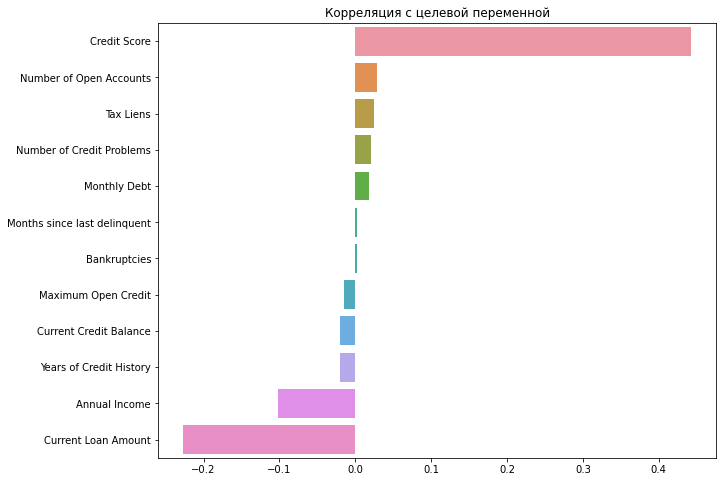

In [40]:
corr_with_target = df_train_base[BASE_NUM_FEATURE_NAMES + [BASE_TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

**Наблюдаем сильную прямую корреляцию целевой переменной с количественным признаком `'Credit Score'` и обратную корреляцию с признаками `'Annual Income'` и `'Current Loan Amount'`. Повышение качества модели будет происходить за счет коррекции (обработки выбросов/пропусков) в первую очередь этих признаков.**

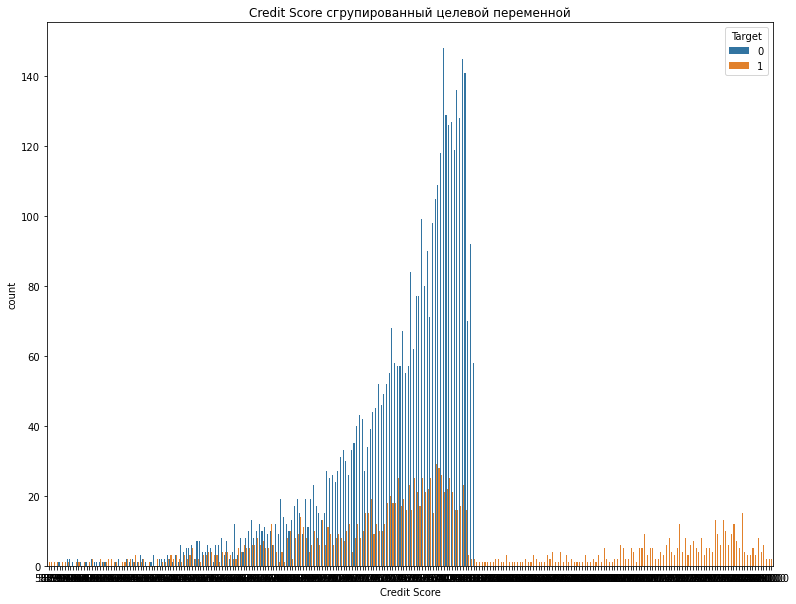

CPU times: total: 3.17 s
Wall time: 3.15 s


In [41]:
%%time
plt.figure(figsize=(13, 10))

sns.countplot(x="Credit Score", hue=BASE_TARGET_NAME, data=df_train_base)
plt.title('Credit Score сгрупированный целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

#### Матрица корреляции признаков для обучающей выборки

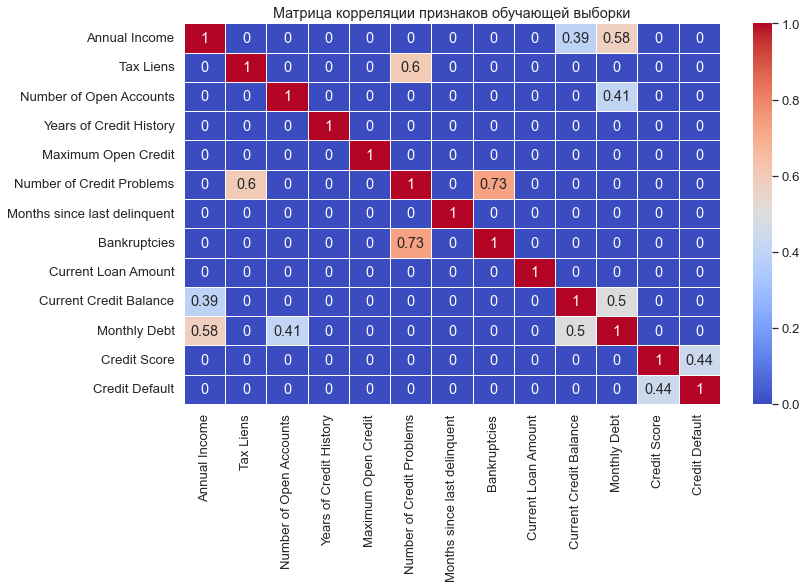

In [42]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_train_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков обучающей выборки')
plt.show()

Видим сильную корреляцию ($\geq 0,5$) следующих признаков:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,73$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,58$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,6$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

### Обзор тестовой выборки

In [43]:
df_test_base.head().T

,0,1,2,3,4
Home Ownership,Rent,Rent,Home Mortgage,Home Mortgage,Home Mortgage
Annual Income,NaN,231838.0,1152540.0,1220313.0,2340952.0
Years in current job,4 years,1 year,3 years,10+ years,6 years
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,9.0,6.0,10.0,16.0,11.0
Years of Credit History,12.5,32.7,13.7,17.0,23.6
Maximum Open Credit,220968.0,55946.0,204600.0,456302.0,1207272.0
Number of Credit Problems,0.0,0.0,0.0,0.0,0.0
Months since last delinquent,70.0,8.0,NaN,70.0,NaN
Bankruptcies,0.0,0.0,0.0,0.0,0.0


In [44]:
df_test_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Из описания тестовой выборки видим, что есть пропуски в признаках:
 - Annual Income
 - Years in current job
 - Months since last delinquent
 - Credit Score
 - Bankruptcies
 
Пропуски в тех же признаках, что и в обучающей выборке.

In [45]:
df_test_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,1987.0,1.366922e+06,9.171252e+05,106533.0,852311.50,1178475.0,1629734.5,14975610.0
Tax Liens,2500.0,3.520000e-02,3.862909e-01,0.0,0.00,0.0,0.0,15.0
Number of Open Accounts,2500.0,1.118440e+01,4.852774e+00,1.0,8.00,10.0,14.0,48.0
Years of Credit History,2500.0,1.832592e+01,7.254659e+00,3.9,13.40,17.0,22.1,53.4
Maximum Open Credit,2500.0,7.105704e+05,1.511983e+06,0.0,278586.00,478676.0,802598.5,54484386.0
Number of Credit Problems,2500.0,1.620000e-01,5.598941e-01,0.0,0.00,0.0,0.0,15.0
Months since last delinquent,1142.0,3.418126e+01,2.202428e+01,0.0,16.00,30.0,50.0,82.0
Bankruptcies,2497.0,1.069283e-01,3.571893e-01,0.0,0.00,0.0,0.0,5.0
Current Loan Amount,2500.0,1.215572e+07,3.226097e+07,15422.0,187126.50,322366.0,522582.5,99999999.0
Current Credit Balance,2500.0,2.963966e+05,3.783020e+05,0.0,110114.50,207385.0,366348.5,6030087.0


#### Анализ числовых признаков

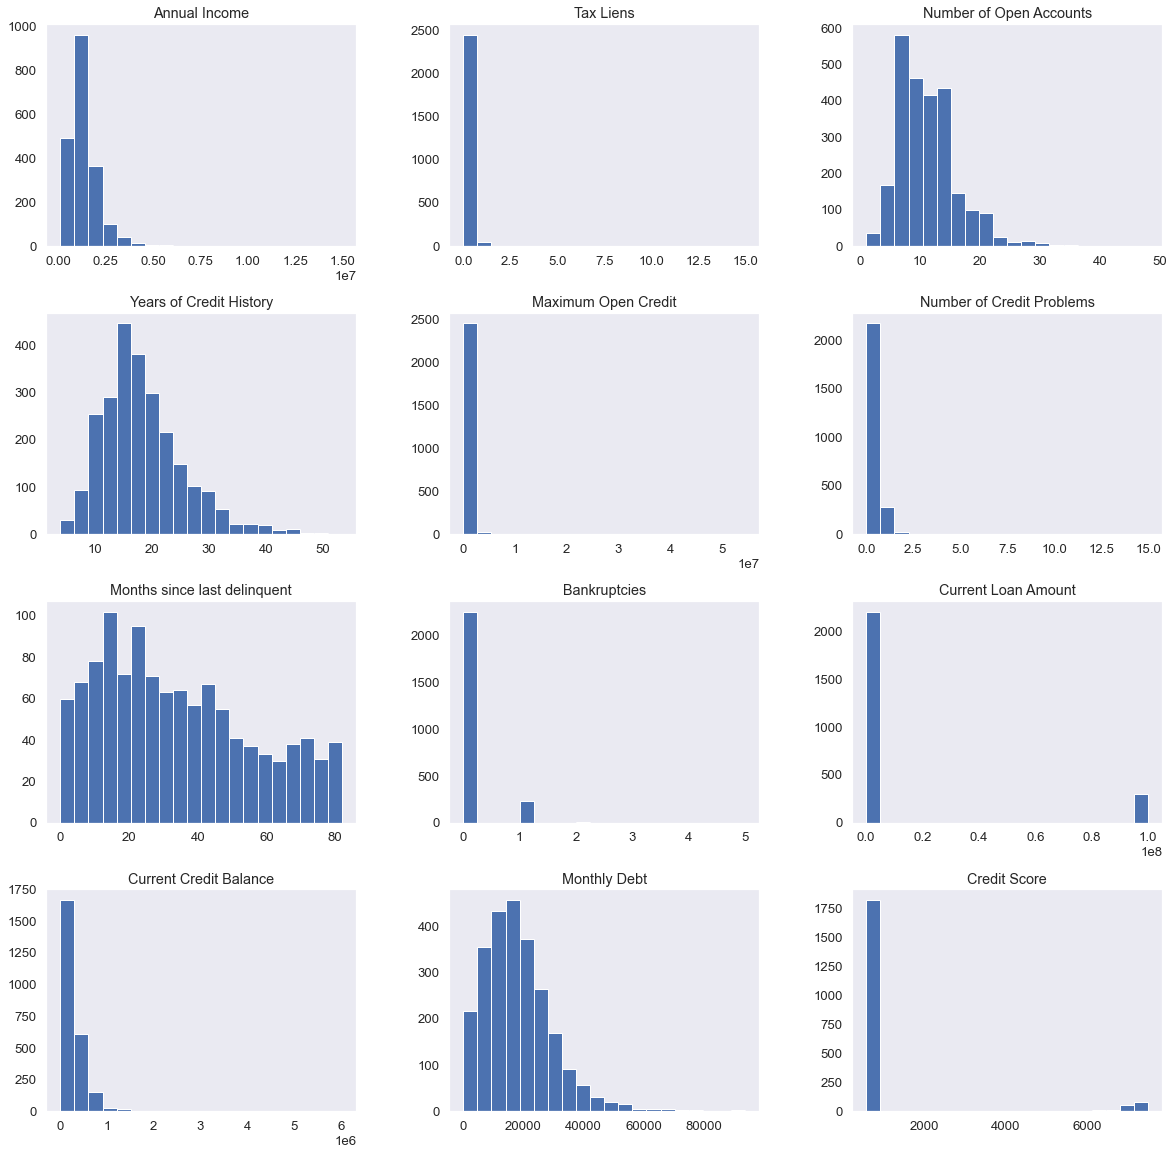

In [46]:
df_test_base[BASE_NUM_FEATURE_NAMES].hist(figsize=(20, 20), bins=20, grid=False);

In [47]:
for num_colname in df_test_base.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_test_base[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1025145.0    3
1328803.0    3
1214993.0    3
1237109.0    3
1204619.0    2
            ..
763838.0     1
1221168.0    1
651377.0     1
1735479.0    1
1694439.0    1
Name: Annual Income, Length: 1929, dtype: int64
****************************************************************************************************

Tax Liens

0.0     2445
1.0       45
2.0        5
5.0        1
4.0        1
6.0        1
3.0        1
15.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     245
8.0     223
10.0    218
11.0    211
12.0    204
6.0     183
13.0    178
7.0     176
14.0    159
5.0     106
15.0     97
16.0     81
17.0     66
4.0      63
18.0     52
19.0     46
20.0     37
21.0     29
3.0      29
22.0     26
23.0     17
27.0     10
24.0      9
2.0       7
30.0      6
25.0      6
26.0      5
28.0      3
33.0      2
31.0      1
1.0       1
36.0      1
29.0      1
34

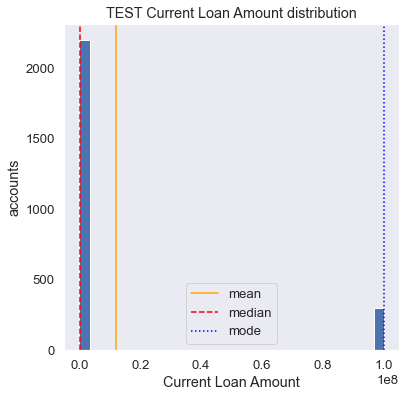

In [48]:
df_test_base['Current Loan Amount'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Current Loan Amount'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Current Loan Amount'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_test_base['Current Loan Amount'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Current Loan Amount')
plt.title('TEST Current Loan Amount distribution')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Current Loan Amount', ylabel='Home Ownership'>

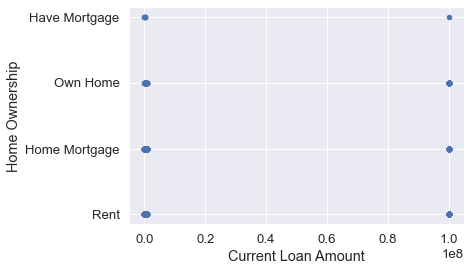

In [49]:
df_test_base.plot(x='Current Loan Amount', y='Home Ownership', kind='scatter')

In [50]:
Current_Loan_Amount_gap_filter = df_test_base['Current Loan Amount'] > 99999000
df_test_base.loc[Current_Loan_Amount_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
17,Home Mortgage,1246495.0,9 years,0.0,10.0,22.9,357456.0,0.0,40.0,0.0,debt consolidation,Short Term,99999999.0,294823.0,21086.0,729.0
22,Own Home,960735.0,8 years,0.0,17.0,11.8,512380.0,0.0,29.0,0.0,debt consolidation,Short Term,99999999.0,164179.0,17133.0,733.0
33,Rent,743888.0,1 year,0.0,11.0,20.0,927124.0,0.0,18.0,0.0,debt consolidation,Short Term,99999999.0,303468.0,15002.0,735.0
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.7,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1764321.0,29184.0,737.0
59,Rent,1984512.0,5 years,0.0,11.0,10.5,286088.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,134653.0,25964.0,745.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,Rent,5997920.0,2 years,0.0,11.0,17.6,1178584.0,0.0,46.0,0.0,debt consolidation,Short Term,99999999.0,350151.0,39686.0,750.0
2457,Home Mortgage,1437502.0,10+ years,0.0,16.0,13.0,750970.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,71991.0,25396.0,747.0
2461,Rent,613225.0,3 years,0.0,6.0,16.8,188078.0,0.0,NaN,0.0,other,Short Term,99999999.0,13319.0,7665.0,749.0
2467,Home Mortgage,939075.0,4 years,0.0,21.0,16.7,577940.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,269534.0,17216.0,737.0


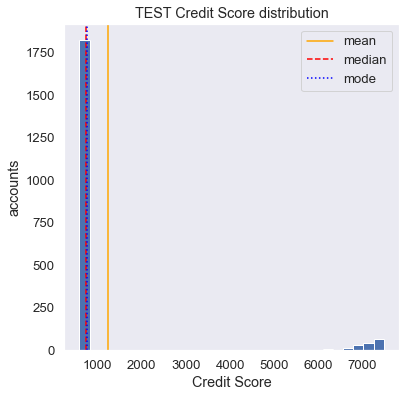

In [51]:
df_test_base['Credit Score'].hist(figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Credit Score'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Credit Score'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_test_base['Credit Score'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Credit Score')
plt.title('TEST Credit Score distribution')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Credit Score', ylabel='Home Ownership'>

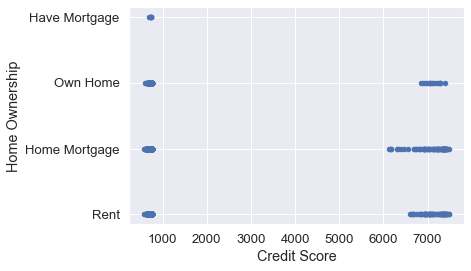

In [52]:
df_test_base.plot(x='Credit Score', y='Home Ownership', kind='scatter')

In [53]:
Credit_Score_gap_filter = df_test_base['Credit Score'] > 1000
df_test_base.loc[Credit_Score_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
12,Home Mortgage,1054614.0,2 years,0.0,11.0,14.0,306328.0,0.0,69.0,0.0,debt consolidation,Short Term,155408.0,202388.0,14940.0,7030.0
41,Home Mortgage,1735498.0,1 year,0.0,10.0,13.2,1584506.0,0.0,NaN,0.0,debt consolidation,Short Term,777172.0,758119.0,30371.0,7320.0
54,Home Mortgage,1602403.0,9 years,0.0,13.0,18.9,690514.0,0.0,47.0,0.0,home improvements,Long Term,695266.0,365560.0,16959.0,6340.0
58,Home Mortgage,1238895.0,6 years,0.0,22.0,17.5,939378.0,0.0,NaN,0.0,debt consolidation,Short Term,393866.0,499757.0,26017.0,7140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,Home Mortgage,1030902.0,10+ years,0.0,14.0,25.8,871838.0,0.0,NaN,0.0,debt consolidation,Long Term,533346.0,430692.0,27319.0,7300.0
2470,Home Mortgage,1116972.0,8 years,0.0,8.0,14.0,351560.0,0.0,NaN,0.0,debt consolidation,Long Term,258676.0,239552.0,14521.0,6470.0
2472,Home Mortgage,1951110.0,< 1 year,0.0,13.0,24.1,440506.0,1.0,NaN,1.0,debt consolidation,Short Term,129096.0,92454.0,25852.0,7410.0
2477,Rent,667603.0,2 years,0.0,5.0,12.3,333366.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,152589.0,7622.0,7480.0


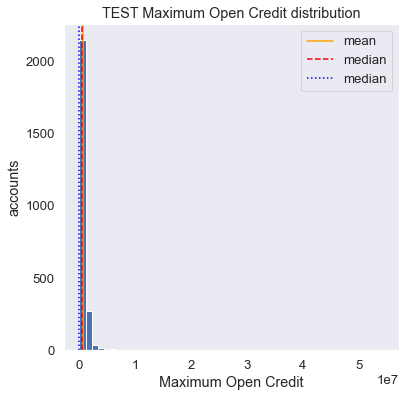

In [54]:
df_test_base['Maximum Open Credit'].hist(
    figsize=(6, 6), bins=50, grid=False)
plt.axvline(x=df_test_base['Maximum Open Credit'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Maximum Open Credit'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_test_base['Maximum Open Credit'].mode(
)[0], label='median', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Maximum Open Credit')
plt.title('TEST Maximum Open Credit distribution')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Home Ownership'>

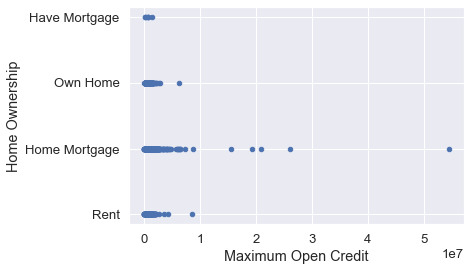

In [55]:
df_test_base.plot(x='Maximum Open Credit', y='Home Ownership', kind='scatter')

In [56]:
df_test_base.nlargest(5, 'Maximum Open Credit')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
228,Home Mortgage,3356255.0,10+ years,0.0,20.0,17.2,54484386.0,0.0,NaN,0.0,home improvements,Long Term,777238.0,5176018.0,42792.0,695.0
1568,Home Mortgage,1236292.0,10+ years,0.0,18.0,32.8,26069956.0,0.0,NaN,0.0,buy a car,Short Term,65560.0,697965.0,23232.0,751.0
2152,Home Mortgage,NaN,10+ years,0.0,16.0,32.3,20842404.0,0.0,NaN,0.0,debt consolidation,Short Term,612502.0,6030087.0,75206.0,NaN
584,Home Mortgage,1313413.0,7 years,0.0,11.0,21.5,19185386.0,0.0,40.0,0.0,other,Long Term,495660.0,2236832.0,6906.0,743.0
222,Home Mortgage,2807535.0,10+ years,0.0,12.0,19.3,15568542.0,0.0,NaN,0.0,buy house,Short Term,99999999.0,3240374.0,27607.0,750.0


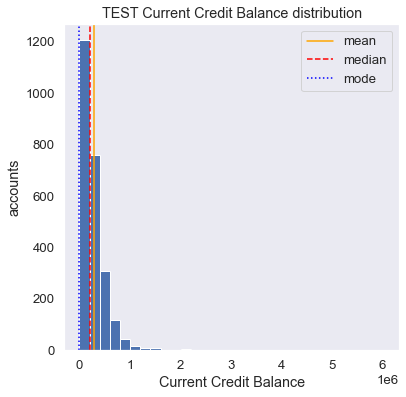

In [57]:
df_test_base['Current Credit Balance'].hist(
    figsize=(6, 6), bins=30, grid=False)
plt.axvline(x=df_test_base['Current Credit Balance'].mean(),
            label='mean', color='orange')
plt.axvline(x=df_test_base['Current Credit Balance'].median(
), label='median', linestyle='--', color='red')
plt.axvline(x=df_test_base['Current Credit Balance'].mode(
)[0], label='mode', linestyle=':', color='blue')
plt.ylabel('accounts')
plt.xlabel('Current Credit Balance')
plt.title('TEST Current Credit Balance distribution')
plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Home Ownership', ylabel='Current Credit Balance'>

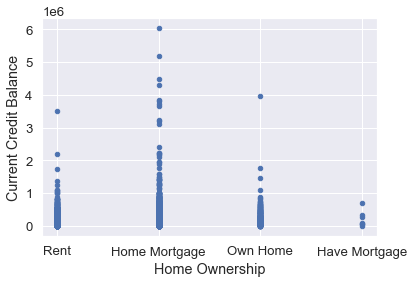

In [58]:
df_test_base.plot(x='Home Ownership', y='Current Credit Balance', kind='scatter')

In [59]:
Current_Credit_Balance_gap_filter = df_test_base['Current Credit Balance'] > 1000000
df_test_base.loc[Current_Credit_Balance_gap_filter]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
42,Rent,NaN,5 years,0.0,30.0,15.8,1661484.0,0.0,NaN,0.0,other,Long Term,296560.0,1093412.0,68721.0,NaN
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.7,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,1764321.0,29184.0,737.0
173,Home Mortgage,1683210.0,10+ years,0.0,18.0,22.2,1859418.0,0.0,NaN,0.0,debt consolidation,Long Term,731412.0,1013308.0,33285.0,675.0
176,Home Mortgage,3725900.0,5 years,0.0,22.0,27.5,5926250.0,0.0,0.0,0.0,debt consolidation,Long Term,754996.0,3209062.0,69550.0,686.0
222,Home Mortgage,2807535.0,10+ years,0.0,12.0,19.3,15568542.0,0.0,NaN,0.0,buy house,Short Term,99999999.0,3240374.0,27607.0,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,Home Mortgage,2423317.0,< 1 year,0.0,17.0,17.5,2599674.0,0.0,NaN,0.0,debt consolidation,Long Term,755458.0,1252803.0,27343.0,663.0
2301,Own Home,1889550.0,10+ years,0.0,7.0,26.0,1297208.0,0.0,NaN,0.0,debt consolidation,Short Term,525096.0,1102380.0,26611.0,746.0
2341,Home Mortgage,2551149.0,10+ years,0.0,9.0,21.0,4707758.0,0.0,NaN,0.0,buy a car,Short Term,175054.0,1508410.0,11012.0,747.0
2487,Home Mortgage,NaN,10+ years,0.0,24.0,36.6,3341228.0,0.0,NaN,0.0,debt consolidation,Short Term,455950.0,1255235.0,44682.0,NaN


**В тестовом (TEST) сете выбросы в тех же признаках, что и в обучающем (TRAIN):**<br>
 - 297 значений в признаке `Current Loan Amount`равные 99 999 999.0;
 - 160 значений признака `Credit Score` более 1000;
 - 63 значения `Current Credit Balance` более 1 000 000 - можно отнести к выбросам и обработать в дальнейшем.

Алгоритм бработки выбросов аналогичен обучающей выборке.

#### Анализ категориальных признаков

In [60]:
for cat_colname in df_train_base.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' +
          str(df_train_base[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

В целом тестовая и обучающая выборки сопоставимы по признакам. Имеют одинаковые проблемы с выбросами и пропусками. Следовательно могут обрабатываться одинаково.

#### Матрица корреляции признаков для тестовой выборки

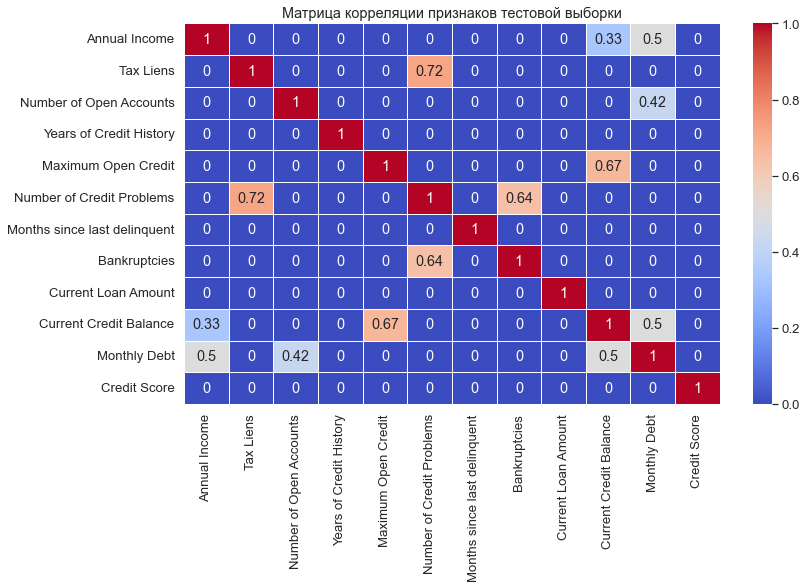

In [61]:
plt.figure(figsize=(12, 7))

sns.set(font_scale=1.2)

corr_matrix = df_test_base.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции признаков тестовой выборки')
plt.show()

Сильная ($\geq 0,5$) корреляция сохраняется на том же уровне на тех же признаках, что и в обучающем сете:
 - `'Number of Credit Problems'` $\iff$ `'Bankruptcies'` $=0,64$
 - `'Annual Income'` $\iff$ `'Monthly Debt'` $=0,5$
 - `'Tax Liens'` $\iff$ `'Number of Credit Problems'` $=0,72$
 - `'Monthly Debt'` $\iff$ `'Current Credit Balance'` $=0,5$

Кроме того добавилась корреляция на признаках `'Current Credit Balance'` $\iff$ `'Maximum Open Credit'` $=0,67$

Используя матрицы корреляции признаков можно сократить их количество путем объединения во время финальной доработки модели. Тем самым мы понизим размерность, что позволит ускорить работу модели и снизит сложность обработки.

## 3. Предобработка данных
---
**Перед обработкой данных скопируем сеты в новые переменные и дальнейшие манипуляции будем проводить с ними.**

In [62]:
df_train = df_train_base.copy()
df_test = df_test_base.copy()

**Далее работаем с сэтом `TRAIN`**

***

### Отбор признаков

In [63]:
TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Years of Credit History',
                          'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                          'Credit Score']


CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens',
                     'Number of Open Accounts', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

### Обработка выбросов

 - Выбросы в `Credit Score` делим на 10.
 - Выбросы в `Current Loan Amount, Maximum Open Credit` заменяем на `NaN` и затем обрабатывем как пропуски.
 - Выбросы в `Current Credit Balance` пока не трогаем. Если понадобится - вернемся к ним в дальнейшем.

In [64]:
OUTLIER_VALUES_FEATURE_NAMES = ['Maximum Open Credit', 'Current Loan Amount']

In [65]:
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] = df_train['Credit Score'] / 10

In [66]:
# использование threshold=99 999 000 позволяет обработать только признаки
# 'Maximum Open Credit' и 'Current Loan Amount', не затрагивая остальные
for feature_name in OUTLIER_VALUES_FEATURE_NAMES:
    df_train = process_outlier_values(df_train, feature_name, threshold=99999000)
    print(f'TRAIN [{feature_name}]: {df_train[feature_name].isna().sum()}')

TRAIN [Maximum Open Credit]: 3
TRAIN [Current Loan Amount]: 870


### Обработка пропусков

Все пропуски заполним с помощью $\mathsf{sklearn.impute.IterativeImputer}$

Для применения $\mathsf{IterativeImputer}$ все данные должны быть численными $\mathsf{float}$. Для `Years in current job` заменим категории по словарю вручную, а остальные строковые категории перенумеруем с помощью цикла $\mathsf{for...in}$

Для повышения качества модели при необходимости можно пожертвовать следующим признаками:
 - `Bankruptcies`
 - `Years in current job`
 - `Months since last delinquent`

### Обработка категориальных признаков

In [67]:
%%time
df_train = process_cat_features(df_train)

{'Home Ownership': {'Own Home': 0, 'Home Mortgage': 1, 'Rent': 2, 'Have Mortgage': 3}, 'Purpose': {'debt consolidation': 0, 'other': 1, 'home improvements': 2, 'take a trip': 3, 'buy a car': 4, 'small business': 5, 'business loan': 6, 'wedding': 7, 'educational expenses': 8, 'buy house': 9, 'medical bills': 10, 'moving': 11, 'major purchase': 12, 'vacation': 13, 'renewable energy': 14}, 'Term': {'Short Term': 0, 'Long Term': 1}}
CPU times: total: 31.2 ms
Wall time: 23.9 ms


In [68]:
for num_colname in df_train.select_dtypes(include='float64').columns:
    if df_train[num_colname].isna().sum() > 0:
        print(f'TRAIN [{num_colname}]: {df_train[num_colname].isna().sum()} NaN values')

TRAIN [Annual Income]: 1557 NaN values
TRAIN [Years in current job]: 371 NaN values
TRAIN [Maximum Open Credit]: 3 NaN values
TRAIN [Months since last delinquent]: 4081 NaN values
TRAIN [Bankruptcies]: 14 NaN values
TRAIN [Current Loan Amount]: 870 NaN values
TRAIN [Credit Score]: 1557 NaN values


~~Перед применением `IterativeImputer` отделим `Credit Default` от датафрейма (чтобы не поменять тип данных). После обработки вернем в сет. Также переведем все значения во `float`.~~

Данное действие снижает качество моделей

**Заполняем пропуски с помощью $\mathsf{IterativeImputer}$**

In [69]:
imp = IterativeImputer(random_state=0)
df_train = pd.DataFrame(imp.fit_transform(df_train), columns=df_train.columns)

~~*``IterativeImputer`` после своей работы оставляет значения вида `-0.004790385850827195` в `Bankruptcies` или `7.498667970005177` в `Years in current job`. Необходимо это исправить, так как такие значения в категориальных признаках вносят ошибку. т. к. не дают однозначного ответа о категории. Кроме того целые и дробные значения обрабатываются по-разному, что влечет за собой увеличение времени работы скрипта.
Произведем следующие операции:*~~

~~ - *значения `Years in current job`больше 10 заменим на 10*~~

~~ - *значения `Bankruptcies` около 0 заменим на 0*~~

~~ - *все остальные значения с "хвостами" округлим до целого, т. к. в сете не было дробных значений кроме признака `Years of Credit History`*~~

~~ - *внесем все эти операции в одну функцию*~~

~~*NB! Тред про [округление](https://overcoder.net/q/522081/%D0%BE%D0%BA%D1%80%D1%83%D0%B3%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B5%D0%B9-%D0%B2-pandas-dafaframe) значений в ``Pandas.DataFrame``*~~

**Применение округления к полученным с помощью ``IterativeImputer`` значениям сильно снижает качество модели. Применять эти операции мы не будем.**

**Переведем категориальные признаки из `float` в `int`**

In [70]:
df_train[CAT_FEATURE_NAMES] = df_train[CAT_FEATURE_NAMES].astype(int)

 ### ~~*Генерация новых признаков*~~

~~1. *`Home Ownership` и `Purpose` преведем в цифру вероятности возврата кредита.*~~
***
**Введение сгенерированных признаков повышает качество модели `CatBoost`, но снижает качество модели `LightGBM`. При этом генерация признаков путем аггрегации с целевой переменной не позволяет в дальнейшем применить модель к тестовой выборке - там нет целевой переменной.**

### Разбиение на `train` и `valid`

In [71]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      shuffle=True,
                                                      test_size=0.2,
                                                      random_state=21,
                                                      stratify=y
                                                      )

print('Target variable class distribution in sets:' + '\n' + ('_' * 50))
print(
    f'TRAIN_train:\n\n0: {y_train.value_counts()[0]}  {round((y_train.value_counts(normalize=True)[0]), 6)}\n1: {y_train.value_counts()[1]}  {round((y_train.value_counts(normalize=True)[1]), 6)}')
print('-' * 50)
print(
    f'TRAIN_valid:\n\n0: {y_valid.value_counts()[0]}   {round((y_valid.value_counts(normalize=True)[0]), 6)}\n1:  {y_valid.value_counts()[1]}   {round((y_valid.value_counts(normalize=True)[1]), 6)}')

Target variable class distribution in sets:
__________________________________________________
TRAIN_train:

0: 4310  0.718333
1: 1690  0.281667
--------------------------------------------------
TRAIN_valid:

0: 1077   0.718
1:  423   0.282


In [72]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов посли обработки данных: [0] : [1] = {disbalance} : 1')

Дисбаланс классов посли обработки данных: [0] : [1] = 2.5502958579881656 : 1


### Сохранение обучающего и валидационного датасетов

In [73]:
TRAIN_train = pd.concat([X_train, y_train], axis=1)
TRAIN_valid = pd.concat([X_valid, y_valid], axis=1)

In [74]:
df_train.to_csv(TRAIN_FULL_SET_PATH, index=False, encoding='utf-8')
TRAIN_train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
TRAIN_valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

## 4. Построение и оценка базовых моделей
***

### Масштабрование данных

In [75]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()

X_train[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_norm[NUM_FEATURE_NAMES])
X_valid[NUM_FEATURE_NAMES] = scaler.transform(X_valid_norm[NUM_FEATURE_NAMES])

**Сохранение модели для масштабирования данных**

In [76]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

~~**_Логистическая регрессия_**~~  
~~**_k ближайших соседей_**~~  
~~**_Дерево решений_**~~

### Бустинговые алгоритмы

~~*__XGBoost__*~~

~~**_LightGBM_**~~

*__CatBoost__*

In [77]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN
 0.704
VALID
 0.371
TRAIN

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      4310
         1.0       0.96      0.56      0.70      1690

    accuracy                           0.87      6000
   macro avg       0.91      0.77      0.81      6000
weighted avg       0.88      0.87      0.86      6000

VALID

              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84      1077
         1.0       0.62      0.26      0.37       423

    accuracy                           0.75      1500
   macro avg       0.69      0.60      0.61      1500
weighted avg       0.72      0.75      0.71      1500

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1008   69
1.0              311  112
CPU times: total: 23.4 s
Wall time: 3.92 s


**_Имеем сильное переобучение на всех бустинговых алгоритмах, что напрямую связано с дисбалансом классов. По нижеописанным результатам поиска и оценки моделей был выбран алгоритм `CatBoost Classifier`. Остальные модели были удалены из скрипта._**

### Балансировка целевой переменной

In [78]:
df = pd.read_csv(TRAIN_FULL_SET_PATH)
df[NUM_FEATURE_NAMES] = scaler.transform(df[NUM_FEATURE_NAMES])

X_b = df[SELECTED_FEATURE_NAMES]
y_b = df[TARGET_NAME]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b,
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=21,
                                                    stratify=y)

In [79]:
%%time
print('[TARGET balancing in progress...]')

# Ничего не делаем с данными
print('Not balanced data processing...\n')

print('Not balanced value counts:\n')    
print(df[TARGET_NAME].value_counts())
print('-' * 100)
stata_not_balanced, models_not_balanced = run_experiment(X_train_b, X_test_b, y_train_b, y_test_b, method='not')
print('\nNot balanced data processing complete\n','=' * 100,'\n')

# Oversampling
print('Oversampling data processing...\n')

df_for_balancing = pd.concat([X_train_b, y_train_b], axis=1)
df_balanced_over = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
print('Oversampling value counts:\n')    
print(df_balanced_over[TARGET_NAME].value_counts())
print('-' * 100)

X_train_b_over = df_balanced_over.drop(columns=TARGET_NAME)
y_train_b_over = df_balanced_over[TARGET_NAME]

stata_balanced_over, models_over = run_experiment(X_train_b_over, X_test_b, y_train_b_over, y_test_b, method='over')
print('\nOversampling data processing complete\n','=' * 100,'\n')

# Undersampling
print('Undersampling data processing...\n')

df_for_balancing = pd.concat([X_train_b, y_train_b], axis=1)
df_balanced_under = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
print('Undersampling value counts:\n')    
print(df_balanced_under[TARGET_NAME].value_counts())
print('-' * 100)

X_train_b_under = df_balanced_under.drop(columns=TARGET_NAME)
y_train_b_under = df_balanced_under[TARGET_NAME]

stata_balanced_under, models_under = run_experiment(X_train_b_under, X_test_b, y_train_b_under, y_test_b, method='under')
print('\nUndersampling data processing complete\n','=' * 100,'\n')

# Undersampling (Tomeklinks)
print('Undersampling (Tomeklinks) data processing...\n')

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train_b, y_train_b)
print('Undersampling (Tomeklinks) value counts:\n')
y_train_balanced.value_counts()
print('-' * 100)

stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test_b, y_train_balanced, y_test_b, method='tomek')
print('\nUndersampling (Tomeklinks) data processing complete\n','=' * 100,'\n')

# Oversampling (SMOTE)
print('Oversampling (SMOTE) data processing...\n')

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_b, y_train_b)
print('Oversampling (SMOTE) value counts:\n')
y_train_balanced.value_counts()
print('-' * 100)

stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test_b, y_train_balanced, y_test_b, method='smote')
print('\nOversampling (SMOTE) data processing complete\n','=' * 100,'\n')

# Сводим результаты вместе
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')

print('[TARGET balancing complete]')

[TARGET balancing in progress...]
Not balanced data processing...

Not balanced value counts:

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64
----------------------------------------------------------------------------------------------------
[16:00:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Not balanced data processing complete

Oversampling data processing...

Oversampling value counts:

0.0    4310
1.0    3380
Name: Credit Default, dtype: int64
----------------------------------------------------------------------------------------------------
[16:00:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed fro

In [80]:
stata_combined

,model_name,f1_macro_train_not,f1_macro_test_not,f1_0_train_not,f1_0_test_not,f1_1_train_not,f1_1_test_not,f1_macro_train_under,f1_macro_test_under,f1_0_train_under,...,f1_0_train_tomek,f1_0_test_tomek,f1_1_train_tomek,f1_1_test_tomek,f1_macro_train_smote,f1_macro_test_smote,f1_0_train_smote,f1_0_test_smote,f1_1_train_smote,f1_1_test_smote
0,lr,0.514695,0.514749,0.831114,0.827251,0.198276,0.202247,0.622200,0.608028,0.648020,...,0.817326,0.826645,0.277254,0.281304,0.641399,0.604495,0.650842,0.731584,0.631955,0.477407
1,knn,0.663255,0.517890,0.856659,0.802013,0.469851,0.233766,0.725950,0.498872,0.739572,...,0.850905,0.787565,0.551849,0.280702,0.825974,0.537076,0.805825,0.664226,0.846122,0.409926
2,tree,1.000000,0.593313,1.000000,0.771442,1.000000,0.415184,1.000000,0.561469,1.000000,...,1.000000,0.770764,1.000000,0.459127,1.000000,0.589741,1.000000,0.731417,1.000000,0.448065
3,xgb,0.956330,0.626225,0.976702,0.836038,0.935958,0.416413,0.996746,0.608159,0.996747,...,0.981660,0.822446,0.956014,0.436718,0.964965,0.645186,0.964925,0.792079,0.965006,0.498294
4,lgbm,0.862671,0.622508,0.934906,0.842460,0.790436,0.402556,0.947333,0.636363,0.947801,...,0.934173,0.837826,0.819383,0.428356,0.884567,0.646401,0.883911,0.784069,0.885223,0.508734
5,cat,0.809812,0.606132,0.915461,0.841402,0.704162,0.370861,0.890824,0.646928,0.891502,...,0.914002,0.831058,0.745702,0.396341,0.876204,0.645398,0.874897,0.783693,0.877511,0.507104


In [81]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.580136,0.593303,0.620776,0.596571,0.611383,0.340171,0.486904,0.449874,0.380424,0.474922
std,0.050831,0.054951,0.050200,0.041875,0.043734,0.096559,0.063318,0.070609,0.079603,0.039184
min,0.514749,0.498872,0.546705,0.534133,0.537076,0.202247,0.382276,0.352392,0.280702,0.409926
25%,0.536746,0.573109,0.589005,0.568906,0.593430,0.268040,0.463804,0.401738,0.310063,0.455401
50%,0.599722,0.608093,0.628511,0.614323,0.624841,0.386708,0.490256,0.454926,0.412349,0.487850
75%,0.618414,0.629312,0.658206,0.625923,0.645345,0.412027,0.536603,0.502169,0.434627,0.504901
max,0.626225,0.646928,0.676987,0.633091,0.646401,0.416413,0.551598,0.535077,0.459127,0.508734


**_Нилучшая метрика на тесте $F1 = 0.550778$. В качестве метода балансировки целевой переменной выбираем `Undersampling`._**

In [82]:
stata_combined.sort_values('f1_macro_test_under', ascending=False).iloc[0]

model_name                   cat
f1_macro_train_not      0.809812
f1_macro_test_not       0.606132
f1_0_train_not          0.915461
f1_0_test_not           0.841402
f1_1_train_not          0.704162
f1_1_test_not           0.370861
f1_macro_train_under    0.890824
f1_macro_test_under     0.646928
f1_0_train_under        0.891502
f1_0_test_under         0.742257
f1_1_train_under        0.890146
f1_1_test_under         0.551598
f1_macro_train_over     0.886122
f1_macro_test_over      0.676987
f1_0_train_over         0.903211
f1_0_test_over          0.818898
f1_1_train_over         0.869033
f1_1_test_over          0.535077
f1_macro_train_tomek    0.829852
f1_macro_test_tomek       0.6137
f1_0_train_tomek        0.914002
f1_0_test_tomek         0.831058
f1_1_train_tomek        0.745702
f1_1_test_tomek         0.396341
f1_macro_train_smote    0.876204
f1_macro_test_smote     0.645398
f1_0_train_smote        0.874897
f1_0_test_smote         0.783693
f1_1_train_smote        0.877511
f1_1_test_

**_Нилучший результат при данном подходе показывет алгоритм `CatBoost Classifier`._**

In [83]:
model_catb_under = models_under['cat']

In [84]:
pred_train = model_catb_under.predict(X_train_b_under)
pred_test = model_catb_under.predict(X_test_b)

evaluate_preds(model_catb_under, X_train_b_under, X_test_b, y_train_b_under, y_test_b)

TRAIN
 0.89
VALID
 0.552
TRAIN

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1690
         1.0       0.90      0.88      0.89      1690

    accuracy                           0.89      3380
   macro avg       0.89      0.89      0.89      3380
weighted avg       0.89      0.89      0.89      3380

VALID

              precision    recall  f1-score   support

         0.0       0.85      0.66      0.74      1077
         1.0       0.45      0.71      0.55       423

    accuracy                           0.67      1500
   macro avg       0.65      0.69      0.65      1500
weighted avg       0.74      0.67      0.69      1500

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             707  370
1.0             121  302


**_Имеется сильное переобучение необходимо подбирать параметры._**

## 5. Выбор лучшей модели и подбор гиперпараметров

**_При андерсемплинге весовые коэффициенты классов равны._**

In [85]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, 1],
                                     )
model_catb.fit(X_train_b_under, y_train_b_under)

evaluate_preds(model_catb, X_train_b_under, X_test_b, y_train_b_under, y_test_b)

TRAIN
 0.845
VALID
 0.541
TRAIN

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.85      1690
         1.0       0.85      0.84      0.84      1690

    accuracy                           0.85      3380
   macro avg       0.85      0.85      0.85      3380
weighted avg       0.85      0.85      0.85      3380

VALID

              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70      1077
         1.0       0.42      0.76      0.54       423

    accuracy                           0.64      1500
   macro avg       0.64      0.67      0.62      1500
weighted avg       0.74      0.64      0.66      1500

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             637  440
1.0             103  320
CPU times: total: 1min 8s
Wall time: 28.4 s


In [86]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, 1],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=20,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall'])

model_catb.fit(X_train_b_under, y_train_b_under, plot=True, eval_set=(X_test_b, y_test_b))

evaluate_preds(model_catb, X_train_b_under, X_test_b, y_train_b_under, y_test_b)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN
 0.661
VALID
 0.535
TRAIN

              precision    recall  f1-score   support

         0.0       0.66      0.61      0.63      1690
         1.0       0.64      0.69      0.66      1690

    accuracy                           0.65      3380
   macro avg       0.65      0.65      0.65      3380
weighted avg       0.65      0.65      0.65      3380

VALID

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73      1077
         1.0       0.43      0.70      0.53       423

    accuracy                           0.66      1500
   macro avg       0.64      0.67      0.63      1500
weighted avg       0.73      0.66      0.67      1500

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             686  391
1.0             126  297
CPU times: total: 1.75 s
Wall time: 969 ms


In [87]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.7065088757396449,
  'Logloss': 0.6386399706067221,
  'F1': 0.6723020569174415,
  'Precision:use_weights=false': 0.6456736035049289,
  'Precision:use_weights=true': 0.6456736035049289,
  'Recall:use_weights=true': 0.7065088757396449},
 'validation': {'Recall:use_weights=false': 0.7021276595744681,
  'Logloss': 0.6421231748790602,
  'F1': 0.5346534653465346,
  'Precision:use_weights=false': 0.43517138599105815,
  'Precision:use_weights=true': 0.43517138599105815,
  'Recall:use_weights=true': 0.7021276595744681}}

_**Внесение поправки по классам снижает степень переобученния. Необходимо подобрать гиперпараметры.**_

### Подбор гиперпараметров

In [88]:
frozen_params = {
    'class_weights': [1, 1],
    'silent': True,
    'random_state': 21,
    'cat_features': CAT_FEATURE_NAMES,
    'eval_metric': 'F1',
    'early_stopping_rounds': 20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [89]:
params = {'iterations': [50, 200, 500, 700, 1000],
          'max_depth': [3, 5, 7, 9, 11],
          'reg_lambda': [1, 1.5, 2, 2.5, 3]}

In [90]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [91]:
%%time
grid_search = model_catb.grid_search(
    params, X_train_b_under, y_train_b_under, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.651026393
bestIteration = 42

0:	loss: 0.6510264	best: 0.6510264 (0)	total: 933ms	remaining: 1m 55s

bestTest = 0.6520467836
bestIteration = 43

1:	loss: 0.6520468	best: 0.6520468 (1)	total: 1.82s	remaining: 1m 52s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6501457726
bestIteration = 14

2:	loss: 0.6501458	best: 0.6520468 (1)	total: 2.45s	remaining: 1m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6590909091
bestIteration = 2

3:	loss: 0.6590909	best: 0.6590909 (3)	total: 2.84s	remaining: 1m 26s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6501457726
bestIteration = 4

4:	loss: 0.6501458	best: 0.6590909 (3)	total: 3.27s	remaining: 1m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6521106259
bestIteration = 23

5:	loss: 0.6521106	best: 0.6590909 (3)	total: 4.02s	remaining: 1m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6491994178
bestIteration = 7


Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6570188133
bestIteration = 0

50:	loss: 0.6570188	best: 0.6725146 (30)	total: 54.2s	remaining: 1m 18s

bestTest = 0.6656976744
bestIteration = 39

51:	loss: 0.6656977	best: 0.6725146 (30)	total: 55.6s	remaining: 1m 18s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6638054363
bestIteration = 5

52:	loss: 0.6638054	best: 0.6725146 (30)	total: 56.3s	remaining: 1m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6638054363
bestIteration = 5

53:	loss: 0.6638054	best: 0.6725146 (30)	total: 57.1s	remaining: 1m 15s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6638054363
bestIteration = 5

54:	loss: 0.6638054	best: 0.6725146 (30)	total: 58s	remaining: 1m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6598837209
bestIteration = 1

55:	loss: 0.6598837	best: 0.6725146 (30)	total: 59.1s	remaining: 1m 12s
Stopped by overfitting detector  (2

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6821480406
bestIteration = 119

99:	loss: 0.6821480	best: 0.6954023 (80)	total: 3m 16s	remaining: 49.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6848920863
bestIteration = 18

100:	loss: 0.6848921	best: 0.6954023 (80)	total: 3m 19s	remaining: 47.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6734397678
bestIteration = 15

101:	loss: 0.6734398	best: 0.6954023 (80)	total: 3m 22s	remaining: 45.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6628407461
bestIteration = 1

102:	loss: 0.6628407	best: 0.6954023 (80)	total: 3m 24s	remaining: 43.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.667638484
bestIteration = 3

103:	loss: 0.6676385	best: 0.6954023 (80)	total: 3m 25s	remaining: 41.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6637681159
bestIteration = 2

104:	loss: 0.6637681	best: 0.6954023 (80)	tot

In [92]:
grid_search

{'params': {'depth': 9, 'l2_leaf_reg': 1, 'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29],
              'test-F1-mean': [0.6457107238160098,
               0.6615595819875205,
               0.6607049439746152,
               0.6581901107115699,
               0.6632931138308894,
               0.6585317024318615,
               0.660657680069097,
               0.6601047702143229,
               0.6602581356175848,


In [93]:
model_catb.best_score_

{'learn': {'Logloss': 0.40529375478478646, 'F1': 0.8765907073098549}}

In [94]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).describe()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,14.500000,0.659010,0.010398,0.694183,0.006351,0.664760,0.001623,0.647484,0.004370
std,8.803408,0.002931,0.005153,0.009206,0.003085,0.011824,0.000957,0.021323,0.003996
min,0.000000,0.645711,0.004225,0.661570,0.000869,0.652502,0.000100,0.622627,0.000692
25%,7.250000,0.657963,0.007785,0.690695,0.003571,0.653895,0.000884,0.628087,0.001761
50%,14.500000,0.659073,0.009674,0.696974,0.006615,0.661548,0.001555,0.642979,0.002628
75%,21.750000,0.660379,0.011004,0.700819,0.008496,0.672594,0.002323,0.662867,0.004967
max,29.000000,0.663293,0.030192,0.703514,0.013917,0.690316,0.003171,0.689644,0.014266


**Обучение и оценка финальной модели**

**_Не балансируем целевую переменную. Полностью убрали переобучение. Метрики почти равны. При этом подходе Public Score на Kaggle равен 0.56062_**

**_Балансируем целевую переменную методом оверсэмплинга. Присутствует переобучение. Kaggle Public Score равен 0.56962_**

**_Балансируем целевую переменную методом андерсэмплинга. Присутствует переобучение. Kaggle Public Score равен 0.57520_**

In [95]:
%%time

final_model_under = catb.CatBoostClassifier(**frozen_params, iterations=50, max_depth=11, reg_lambda=2.5)
final_model_under.fit(X_train_b_under, y_train_b_under, plot=True, eval_set=(X_test_b, y_test_b))

evaluate_preds(final_model_under, X_train_b_under, X_test_b, y_train_b_under, y_test_b)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN
 0.695
VALID
 0.53
TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.67      1690
         1.0       0.67      0.72      0.69      1690

    accuracy                           0.68      3380
   macro avg       0.68      0.68      0.68      3380
weighted avg       0.68      0.68      0.68      3380

VALID

              precision    recall  f1-score   support

         0.0       0.84      0.62      0.72      1077
         1.0       0.42      0.71      0.53       423

    accuracy                           0.65      1500
   macro avg       0.63      0.66      0.62      1500
weighted avg       0.73      0.65      0.66      1500

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             671  406
1.0             124  299
CPU times: total: 9.53 s
Wall time: 2.61 s


### Подбор оптимального размера выборки, кривая обучения

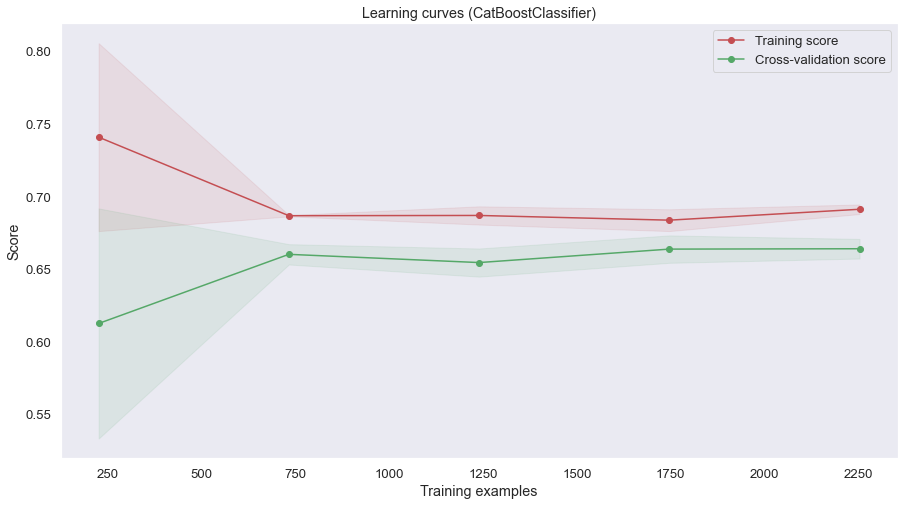

CPU times: total: 328 ms
Wall time: 33 s


In [96]:
%%time
show_learning_curve_plot(final_model_under, X_train_b_under, y_train_b_under)

**_Для обучения модели при подобранных параметрах достаточно 1750 строк в сете_**

### Выбор порога вероятности для определения класса

In [97]:
y_test_b_pred_probs = final_model_under.predict_proba(X_test_b)
y_test_b_pred_probs

array([[0.59160287, 0.40839713],
       [0.56982719, 0.43017281],
       [0.53707738, 0.46292262],
       ...,
       [0.55575564, 0.44424436],
       [0.56718327, 0.43281673],
       [0.47833809, 0.52166191]])

In [98]:
np.where(y_test_b_pred_probs[:, 1] > 0.6, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

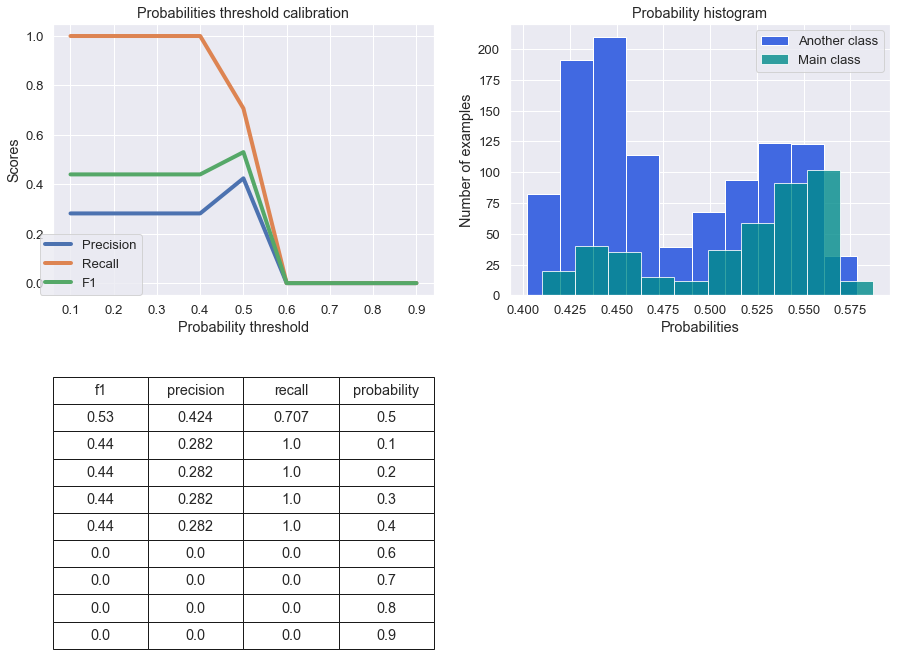

In [99]:
y_test_b_pred_probs = final_model_under.predict_proba(X_test_b)
show_proba_calibration_plots(y_test_b_pred_probs[:, 1], y_test_b)

### Важность признаков

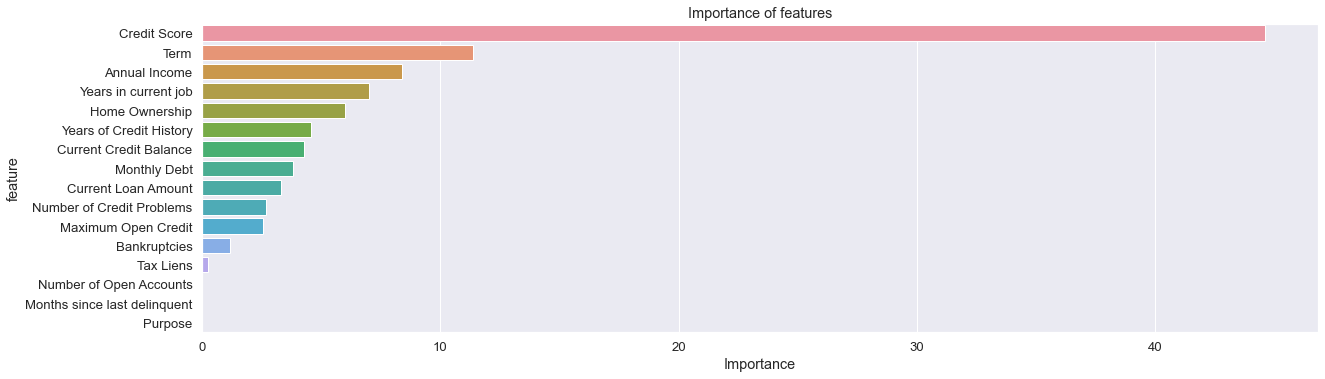

In [100]:
important_features_top = show_feature_importances(
    X_train_b_under.columns, final_model_under.feature_importances_, get_top=20)

In [101]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Number of Credit Problems',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Bankruptcies',
 'Home Ownership',
 'Purpose',
 'Term',
 'Years in current job',
 'Tax Liens']

In [102]:
%%time
frozen_params = {
    'class_weights': [1, 1],
    'silent': True,
    'random_state': 21,
    'cat_features': NEW_CAT_FEATURE_NAMES,
    'eval_metric': 'F1',
    'early_stopping_rounds': 20
}

CPU times: total: 0 ns
Wall time: 0 ns


In [103]:
final_model_under = catb.CatBoostClassifier(**frozen_params,
                                      iterations=50,
                                      max_depth=11,
                                      reg_lambda=2.5)

final_model_under.fit(X_train_b_under, y_train_b_under, eval_set=(X_test_b, y_test_b))

evaluate_preds(final_model_under, X_train_b_under, X_test_b, y_train_b_under, y_test_b)

TRAIN
 0.695
VALID
 0.53
TRAIN

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.67      1690
         1.0       0.67      0.72      0.69      1690

    accuracy                           0.68      3380
   macro avg       0.68      0.68      0.68      3380
weighted avg       0.68      0.68      0.68      3380

VALID

              precision    recall  f1-score   support

         0.0       0.84      0.62      0.72      1077
         1.0       0.42      0.71      0.53       423

    accuracy                           0.65      1500
   macro avg       0.63      0.66      0.62      1500
weighted avg       0.73      0.65      0.66      1500

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             671  406
1.0             124  299


In [104]:
final_model_under.best_score_

{'learn': {'Logloss': 0.6198600752924697, 'F1': 0.7149034303833959},
 'validation': {'Logloss': 0.6408357793142766, 'F1': 0.5301418439716311}}

### Сохранение финальной модели

In [105]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model_under, file)

## 6. Предсказание на тестовом сете

### Подготовка тестового датасета

In [106]:
df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score'] = df_test['Credit Score'] / 10

In [107]:
# использование threshold=99 999 000 позволяет обработать только признаки
# 'Maximum Open Credit' и 'Current Loan Amount', не затрагивая остальные
for feature_name in OUTLIER_VALUES_FEATURE_NAMES:
    df_test = process_outlier_values(df_test, feature_name, threshold=99999000)
    print(f'TEST [{feature_name}]: {df_test[feature_name].isna().sum()}')

TEST [Maximum Open Credit]: 0
TEST [Current Loan Amount]: 297


In [108]:
%%time
df_test = process_cat_features(df_test)

{'Home Ownership': {'Rent': 0, 'Home Mortgage': 1, 'Own Home': 2, 'Have Mortgage': 3}, 'Purpose': {'debt consolidation': 0, 'educational expenses': 1, 'home improvements': 2, 'major purchase': 3, 'other': 4, 'buy a car': 5, 'medical bills': 6, 'buy house': 7, 'business loan': 8, 'take a trip': 9, 'small business': 10, 'moving': 11, 'vacation': 12, 'wedding': 13}, 'Term': {'Short Term': 0, 'Long Term': 1}}
CPU times: total: 15.6 ms
Wall time: 15 ms


In [109]:
for num_colname in df_test.select_dtypes(include='float64').columns:
    if df_test[num_colname].isna().sum() > 0:
        print(f'TRAIN [{num_colname}]: {df_test[num_colname].isna().sum()} NaN values')

TRAIN [Annual Income]: 513 NaN values
TRAIN [Years in current job]: 86 NaN values
TRAIN [Months since last delinquent]: 1358 NaN values
TRAIN [Bankruptcies]: 3 NaN values
TRAIN [Current Loan Amount]: 297 NaN values
TRAIN [Credit Score]: 513 NaN values


In [110]:
imp = IterativeImputer(random_state=0)
df_test = pd.DataFrame(imp.fit_transform(df_test), columns=df_test.columns)

In [111]:
df_test[CAT_FEATURE_NAMES] = df_test[CAT_FEATURE_NAMES].astype(int)

In [112]:
df_test[NUM_FEATURE_NAMES] = scaler.transform(df_test[NUM_FEATURE_NAMES])

In [113]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   int32  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int32  
 3   Tax Liens                     2500 non-null   int32  
 4   Number of Open Accounts       2500 non-null   int32  
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   int32  
 8   Months since last delinquent  2500 non-null   int32  
 9   Bankruptcies                  2500 non-null   int32  
 10  Purpose                       2500 non-null   int32  
 11  Term                          2500 non-null   int32  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Сохранение подготовленного сета

In [114]:
df_test.to_csv(PREPARED_TEST_SET_PATH, index=False, encoding='utf-8')

### Предсказание на тестовом сете

In [115]:
predictions = final_model_under.predict(df_test[final_model_under.feature_names_])

In [116]:
CATB_Classifier_predictions = pd.DataFrame(predictions, columns=['Credit Default'])
CATB_Classifier_predictions['Id'] = CATB_Classifier_predictions.index

In [117]:
CATB_Classifier_predictions = CATB_Classifier_predictions.astype(int)

In [118]:
CATB_Classifier_predictions.value_counts()[1]

Id
907     1
890     1
892     1
895     1
896     1
       ..
5       1
6       1
7       1
8       1
2499    1
Length: 1259, dtype: int64

In [119]:
CATB_Classifier_predictions.to_csv(PREDICTIONS_FILE_PATH, index=False, encoding='utf-8')

In [120]:
%pip list

Package                           Version
--------------------------------- ---------
anaconda-client                   1.8.0
anaconda-navigator                2.1.1
anyio                             3.5.0
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
attrs                             21.4.0
autopep8                          1.6.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.10.0
black                             21.12b0
bleach                            4.1.0
brotlipy                          0.7.0
catboost                          1.0.4
certifi                           2021.10.8
cffi                              1.15.0
chardet                           4.0.0
charset-normalizer                2.0.10
click                             8.0.3
clyent                            1.2.2
colorama              